# Image Classification with DNN

## DATASETS:
(a) Carbonic Anhydrase II (ChEMBL205), a protein lyase,  
(b) Cyclin-dependent kinase 2 (CHEMBL301), a protein kinase,  
(c) ether-a-go-go-related gene potassium channel 1 (HERG) (CHEMBL240), a voltage-gated ion channel,  
(d) Dopamine D4 receptor (CHEMBL219), a monoamine GPCR,  
(e) Coagulation factor X (CHEMBL244), a serine protease,  
(f) Cannabinoid CB1 receptor (CHEMBL218), a lipid-like GPCR and  
(g) Cytochrome P450 19A1 (CHEMBL1978), a cytochrome P450.  
The activity classes were selected based on data availability and as representatives of therapeutically important target classes or as anti-targets.

In [1]:
!nvidia-smi

Sun Mar 20 15:10:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   50C    P8    16W / 240W |    625MiB /  8116MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Import
import pandas as pd
import numpy as np
from pathlib import Path

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')
#from rdkit import Chem
#from rdkit.Chem import AllChem

In [4]:
dataset = 'CHEMBL205'

In [5]:
path = Path('../dataset/13321_2017_226_MOESM1_ESM/')
df = pd.read_csv(path/dataset/f'{dataset}_train_valid.csv')

In [6]:
list(path.iterdir())

[PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL205'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/.ipynb_checkpoints'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL301'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL218'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL219'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL244'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/mol_images'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL1978'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL240')]

In [7]:
DATA = path/'mol_images'

In [8]:
IMAGES = DATA/dataset

# Create train validation split

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
df.is_valid.value_counts()

False    14352
True      3589
Name: is_valid, dtype: int64

In [11]:
len(df[df.is_valid == True]) / len(df[df.is_valid == False])

0.2500696767001115

# Create dataloader

In [12]:
from fastai.vision.all import *

In [13]:
df['Image'] = df['CID'] + '.png'
df.head()

,CID,SMILES,Activity,is_valid,Image
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,1,False,CHEMBL188002.png
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,1,False,CHEMBL364127.png
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,1,False,CHEMBL1683469.png
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],1,False,CHEMBL52564.png
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,1,False,CHEMBL21427.png


In [14]:
images = df['CID'] + ".png"
images.head()

0     CHEMBL188002.png
1     CHEMBL364127.png
2    CHEMBL1683469.png
3      CHEMBL52564.png
4      CHEMBL21427.png
Name: CID, dtype: object

In [15]:
# No flips, some rotation and zoom. Normalize to imagenet_stats as
# we're using pretrained models.
batch_tfms = [*aug_transforms(mult=1.0, do_flip=False, flip_vert=False, 
               max_rotate=20.0, min_zoom=1.0, max_zoom=1.1, max_lighting=0., 
               max_warp=0., p_affine=0.75, p_lighting=0.75, xtra_tfms=None, 
               size=224, mode='bilinear', 
               pad_mode='border', align_corners=True, 
               batch=False, min_scale=1.0), 
              Normalize.from_stats(*imagenet_stats)]

In [16]:
db = DataBlock(
    blocks = (ImageBlock(), CategoryBlock()), 
    get_x=ColReader('Image', pref=IMAGES),
    get_y=ColReader('Activity'), 
    splitter=ColSplitter('is_valid'),
    item_tfms=None, 
    batch_tfms=None,
    )

Oversmaple instead of using class weights to test custom loss function

In [17]:
def val_cols_and_oversample(df, test_size=0.25, random_state=42, oversample=True):
    x_train,x_val = train_test_split(df.index, test_size=test_size, stratify=df['Activity'], 
                                     random_state=random_state)
    
    df.loc[x_train, 'is_valid']=False
    df.loc[x_val, 'is_valid']=True
    # Oversample is_valid=False columns
    if oversample:
        df = pd.concat([*[df.loc[(df.is_valid==False) & (df.Activity==1)]]*10, 
                        *[df.loc[(df.is_valid==False) & (df.Activity==0)]], 
                        df.loc[df.is_valid==True]], 
                       ignore_index=True)
    return df


In [18]:
def get_df(dataset, random_state=42, test_size=0.25, oversample=True):
    df = pd.read_csv(path/dataset/f'{dataset}_cl.csv')
    df = val_cols_and_oversample(df, test_size=test_size, random_state=random_state, oversample=oversample)
    df['Image'] = df['CID'] + '.png'
    return df

In [19]:
def get_df_with_clusters(dataset, n_clusters=100, random_state=42, test_size=0.25):
    df = pd.read_csv(path/dataset/f'{dataset}_cl_ECFP_1024_with_{n_clusters}_clusters.csv')
    values = df.Cluster.value_counts(ascending=True)
    values = values[values < 2].index
    for i in list(values):
        df = df.drop(df[df.Cluster == i].index)
    df.reset_index(drop=True, inplace=True)
    x_train, x_valid = train_test_split(df.index, test_size=test_size, random_state=random_state, stratify=df['Cluster'])
    df.loc[x_train, 'is_valid']=False
    df.loc[x_valid, 'is_valid']=True
    df['Image'] = df['Name'] + '.png'
    return df

In [20]:
df = get_df(dataset)
df.head()

,CID,SMILES,Activity,is_valid,Image
0,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,1,False,CHEMBL364127.png
1,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,1,False,CHEMBL1683469.png
2,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],1,False,CHEMBL52564.png
3,CHEMBL21427,OB(O)c1ccc(OC)cc1,1,False,CHEMBL21427.png
4,CHEMBL1414,O(C)c1cc(cc(OC)c1O)C(=O)[O-],1,False,CHEMBL1414.png


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28948 entries, 0 to 28947
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   CID       28948 non-null  object
 1   SMILES    28948 non-null  object
 2   Activity  28948 non-null  int64 
 3   is_valid  28948 non-null  object
 4   Image     28948 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.1+ MB


In [22]:
IMAGES = DATA/f'{dataset}_cl'
IMAGES

Path('../dataset/13321_2017_226_MOESM1_ESM/mol_images/CHEMBL205_cl')

In [23]:
def get_dls(dataset, bs=64, clustering=False, random_state=42):
    IMAGES = DATA/f'{dataset}_cl'
    if clustering:
        df = get_df_with_clusters(dataset, n_clusters=100)
    else: 
        df = get_df(dataset, oversample=True)
    db = DataBlock(
        blocks = (ImageBlock(), CategoryBlock()), 
        get_x=ColReader('Image', pref=IMAGES),
        get_y=ColReader('Activity'), 
        splitter=ColSplitter('is_valid'),
        item_tfms=None, 
        batch_tfms=None,
        )
    dls = db.dataloaders(df, bs=bs, shuffle_train=True, random_state=42, num_workers=0)
    return dls, df

In [24]:
dls, df = get_dls(dataset, bs=32, clustering=False)

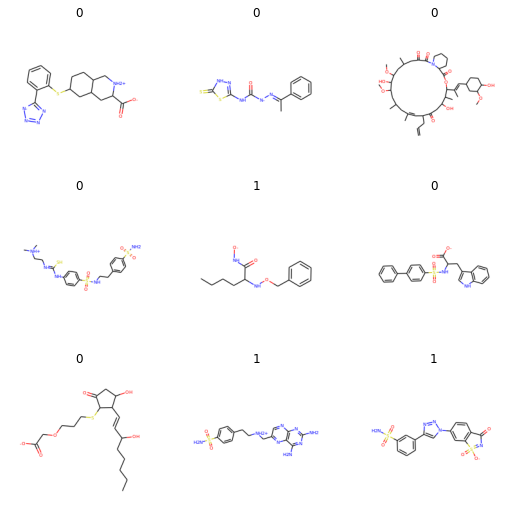

In [25]:
dls.show_batch()

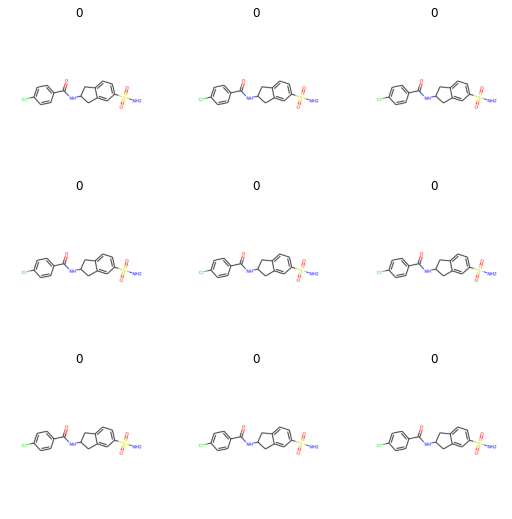

In [26]:
dls.show_batch(unique=True)

# Create class weights

In [27]:
TARGET = 'Activity'

In [28]:
train_df = df[df.is_valid == False]

In [29]:
class_count_df = train_df.groupby(TARGET).count()
class_count_df

,CID,SMILES,is_valid,Image
Activity,,,,
0,12232,12232,12232,12232
1,12230,12230,12230,12230


In [30]:
n_0, n_1 = class_count_df.iloc[0, 0], class_count_df.iloc[1, 0]

In [31]:
w_0 = (n_0 + n_1) / (2.0 * n_0)
w_1 = (n_0 + n_1) / (2.0 * n_1)
w_0, w_1

(0.9999182472204055, 1.0000817661488144)

In [32]:
class_weights=torch.FloatTensor([w_0, w_1]).cuda()

In [33]:
loss_func = CrossEntropyLossFlat(weight=class_weights)

In [34]:
def get_loss_func(df):
    TARGET = 'Activity'
    class_count_df = df.groupby(TARGET).count()
    n_0, n_1 = class_count_df.iloc[0, 0], class_count_df.iloc[1, 0]
    w_0 = (n_0 + n_1) / (2.0 * n_0)
    w_1 = (n_0 + n_1) / (2.0 * n_1)
    class_weights=torch.FloatTensor([w_0, w_1]).cuda()
    loss_func = CrossEntropyLossFlat(weight=class_weights)
    return loss_func

In [35]:
loss_func=get_loss_func(df)

# Train CNN model

In [36]:
from sklearn.metrics import auc,roc_auc_score,recall_score,precision_score,f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns
from utils.losses import * 

In [37]:
from fastai.callback.hook import *

In [38]:
def show_confusion_matrix(learn, dl):
    preds, y = learn.get_preds(dl=dl)
    pred = preds.argmax(axis=1)
    cm = confusion_matrix(y, pred)
    f = sns.heatmap(cm, annot=True, fmt='d')
    plt.show()
    return f

# Cost-sensitive loss function



There's a simple idea behind a Cost-Sensitive Loss: we impose a different penalty to different kind of errors. For illustration purposes, imagine you have a three-class classification problem and you wish to impose a greater penalty to errors in misclassifying class 2 as class 0, but you don't care about the other errors.*

In [39]:
n_classes = 2

In [40]:
cs_loss = CostSensitiveLoss(n_classes, normalization='sigmoid')

In [41]:
print(cs_loss.M)

tensor([[0., 1.],
        [1., 0.]])


In [42]:
M = np.array([[0,10],
              [1,0]], dtype=float)
M /= M.max()
M = torch.from_numpy(M)
M = M.to(torch.float32)
cs_loss.M = M


In [43]:
print(cs_loss.M)

tensor([[0.0000, 1.0000],
        [0.1000, 0.0000]])


**Results**: Just training for 1 epoch, number of False Positives went down, number of False Negatives went up (as expected), but number of True positives also went down which is bad. 

# Regularized cost-sensitive loss function

In our experiments (and elsewhere) we found out that simply using a CS loss leads to lots of trouble in terms of CNNs staying at local minima where they will predict a trivial configuration (all the time the same category), which seems to be very satisfying for this kind of losses. For this reason, we recommend using this as a regularizer for other standard classification losses (just a weighted sum of both, with a weighing parameter `lambd`). \
In our implementation we provide a wrapper for doing this, where you specify a `base_loss` and the regularization parameter `lambd`:


In [44]:
n_classes = 2 
base_loss = 'ce'
lambd = 10
cs_regularized_loss = CostSensitiveRegularizedLoss(n_classes=n_classes, base_loss=base_loss, lambd=lambd)

In [45]:
print(cs_regularized_loss.M)

tensor([[0., 1.],
        [1., 0.]])


In [46]:
M = np.array([[0,10],
              [1,0]], dtype=float)
M /= M.max()
M = torch.from_numpy(M)
M = M.to(torch.float32)
cs_regularized_loss.M = M

In [47]:
print(cs_regularized_loss.M)

tensor([[0.0000, 1.0000],
        [0.1000, 0.0000]])


In [48]:
def show_confusion_matrix(learn, dl):
    preds, y = learn.get_preds(dl=dl)
    pred = preds.argmax(axis=1)
    cm = confusion_matrix(y, pred)
    f = sns.heatmap(cm, annot=True, fmt='d')
    plt.show()
    return f

# Train a cnn model in pytorch

In [49]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

<AxesSubplot:>

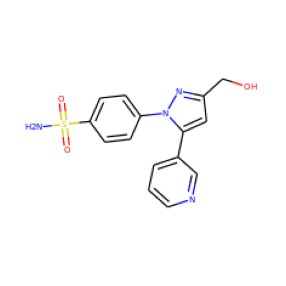

In [50]:
train_x, y = dls.one_batch()
show_image(train_x[0])

In [51]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        #images, labels = images.cuda(), labels.cuda()
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [52]:
class NaturalSceneClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(50176,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,2)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [53]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [54]:
model = NaturalSceneClassification()
model.cuda()

NaturalSceneClassification(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): MaxPool2d(kernel_size=2, stride=2

In [55]:
num_epochs = 2
opt_func = torch.optim.Adam
lr = 0.001#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, dls.train, dls.valid, opt_func)

KeyboardInterrupt: 

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, dls.train, dls.valid, opt_func)

In [77]:
import torchvision.models as models
from torchsummary import summary
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
import copy

In [58]:
model_resnet = models.resnet18(pretrained=True)
model_resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [61]:
features = nn.Sequential(*(list(model_resnet.children())[:-2]))
features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [66]:
model_resnet = model_resnet.cuda()
summary(model_resnet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [328]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        result = {}
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            if phase == 'train':
                dataloaders = dls.train
            else:
                dataloaders = dls.valid
            # Iterate over data.
            for inputs, labels in dataloaders:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders.dataset) 
            result[f'{phase}_loss'] = epoch_loss
            epoch_acc = running_corrects.double() / len(dataloaders.dataset)
            result[f'{phase}_acc'] = epoch_acc
            

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        history.append(result)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [269]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0003, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

In [303]:
def create_model(feature_extract = False):
    model_ft = models.resnet18(pretrained=True)
    
    set_parameter_requires_grad(model_ft, feature_extract)
    
    num_ftrs = model_ft.fc.in_features

    # Here the size of each output sample is set to 2.
    # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
    model_ft.fc = nn.Linear(num_ftrs, 2)

    model_ft = model_ft.cuda()
    
    return model_ft

In [155]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [270]:
model_ft, history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)

Epoch 0/0
----------
train Loss: 0.2197 Acc: 0.9175
val Loss: 0.1539 Acc: 0.9550

Training complete in 1m 42s
Best val Acc: 0.954971


In [166]:
model_ft, history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=7)

Epoch 0/6
----------
train Loss: 0.2142 Acc: 0.9191
val Loss: 0.1404 Acc: 0.9588

Epoch 1/6
----------
train Loss: 0.0820 Acc: 0.9790
val Loss: 0.1122 Acc: 0.9679

Epoch 2/6
----------
train Loss: 0.0428 Acc: 0.9906
val Loss: 0.1054 Acc: 0.9690

Epoch 3/6
----------
train Loss: 0.0238 Acc: 0.9950
val Loss: 0.1093 Acc: 0.9688

Epoch 4/6
----------
train Loss: 0.0206 Acc: 0.9960
val Loss: 0.1335 Acc: 0.9668

Epoch 5/6
----------
train Loss: 0.0193 Acc: 0.9960
val Loss: 0.1147 Acc: 0.9697

Epoch 6/6
----------
train Loss: 0.0181 Acc: 0.9962
val Loss: 0.1178 Acc: 0.9695

Training complete in 12m 5s
Best val Acc: 0.969683


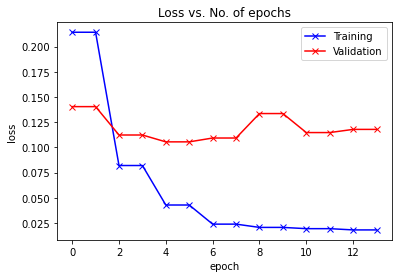

In [167]:
plot_losses(history)

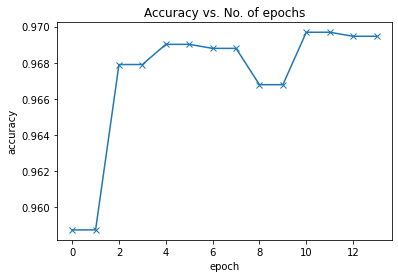

In [168]:
plot_accuracies(history)

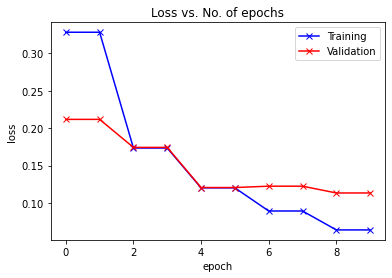

In [164]:
plot_losses(history)

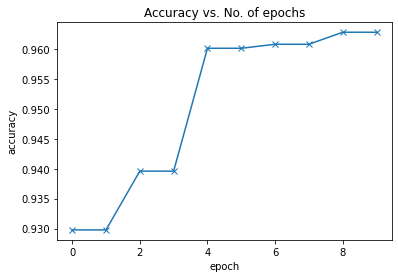

In [158]:
plot_accuracies(history)

In [137]:
model_ft, history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=4)

Epoch 0/3
----------
train Loss: 0.1502 Acc: 0.9473
val Loss: 0.1237 Acc: 0.9681

Epoch 1/3
----------
train Loss: 0.0464 Acc: 0.9877
val Loss: 0.1107 Acc: 0.9670

Epoch 2/3
----------
train Loss: 0.0206 Acc: 0.9942
val Loss: 0.1346 Acc: 0.9690

Epoch 3/3
----------
train Loss: 0.0115 Acc: 0.9965
val Loss: 0.1393 Acc: 0.9708

Training complete in 6m 37s
Best val Acc: 0.970798


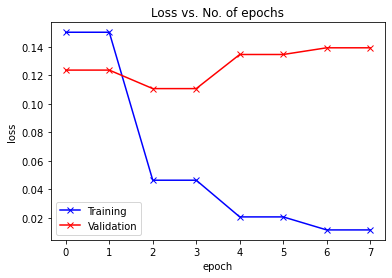

In [152]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'].cpu() for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

#plot_accuracies(history)

def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    train_losses
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

#plot_losses(history)

In [273]:
def show_confusion_matrix(model, dl):
    
    out = torch.Tensor().to(device)
    labels = torch.Tensor().to(device)
    for inputs, y in dl:
        inputs = inputs.to(device)
        y = y.to(device)
        labels = torch.cat([labels, y])
        preds = model(inputs)
        pred = preds.argmax(axis=1)
        out = torch.cat([out, pred])
    out = out.cpu()
    labels = labels.cpu()
    cm = confusion_matrix(labels, out)
    f = sns.heatmap(cm, annot=True, fmt='d')
    plt.show()
    return f

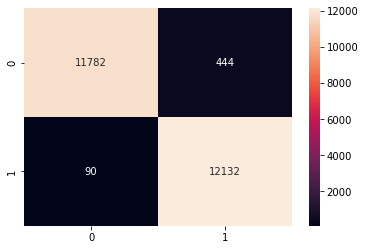

<AxesSubplot:>

In [275]:
show_confusion_matrix(model_ft, dls.train)

# Cost Regularized Loss function

In [288]:
n_classes = 2 
base_loss = 'ce'
lambd = 10
criterion = CostSensitiveRegularizedLoss(n_classes=n_classes, base_loss=base_loss, lambd=lambd)

In [289]:
M = np.array([[0,10],
              [1,0]], dtype=float)
M /= M.max()
M = torch.from_numpy(M)
M = M.to(torch.float32)
criterion.M = M

In [290]:
model_cs = create_model()

In [298]:
lr = 0.0003

In [292]:
# Observe that all parameters are being optimized
optimizer_cs = optim.SGD(model_cs.parameters(), lr=lr, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_cs, step_size=3, gamma=0.1)

In [293]:
model_cs, history_cs = train_model(model_cs, criterion, optimizer_cs, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.4695 Acc: 0.9278
val Loss: 0.3510 Acc: 0.9726

Epoch 1/4
----------
train Loss: 0.1597 Acc: 0.9828
val Loss: 0.3705 Acc: 0.9695

Epoch 2/4
----------
train Loss: 0.0925 Acc: 0.9903
val Loss: 0.3135 Acc: 0.9688

Epoch 3/4
----------
train Loss: 0.0356 Acc: 0.9971
val Loss: 0.3202 Acc: 0.9717

Epoch 4/4
----------
train Loss: 0.0235 Acc: 0.9981
val Loss: 0.3187 Acc: 0.9715

Training complete in 8m 38s
Best val Acc: 0.972581


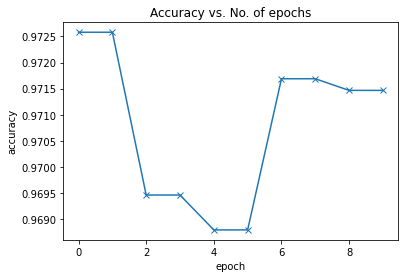

In [294]:
plot_accuracies(history_cs)

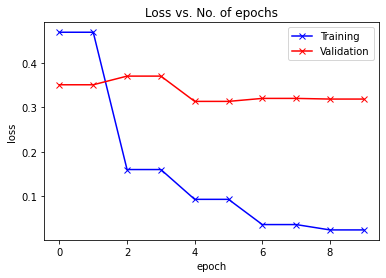

In [295]:
plot_losses(history_cs)

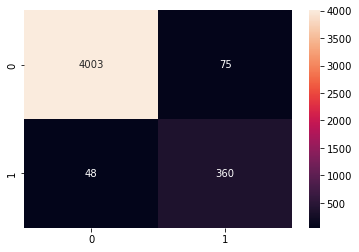

<AxesSubplot:>

In [296]:
show_confusion_matrix(model_cs, dls.valid)

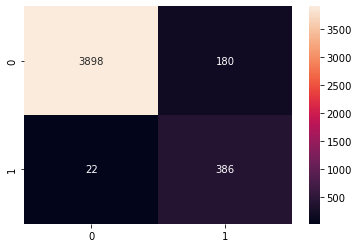

<AxesSubplot:>

In [299]:
show_confusion_matrix(model_ft, dls.valid)

# Feature extracting

In [383]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [384]:
model_cs = create_model(feature_extract=True)

In [385]:
feature_extract = True

In [386]:
params_to_update = model_cs.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_cs.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_cs.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [387]:
# Observe that all parameters are being optimized
optimizer_cs = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [388]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

In [ ]:
model_cs, history_cs = train_model(model_cs, criterion, optimizer_cs, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.3866 Acc: 0.8270


In [ ]:
show_confusion_matrix(model_cs, dls.valid)

In [ ]:
num_epochs = min(len(history_ft), len(history_cs))
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [history_cs[i]['val_acc'].cpu().numpy() for i in range(0, num_epochs)]
shist = [history_ft[i]['val_acc'].cpu().numpy() for i in range(0, num_epochs)]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0.5,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [366]:
feature_extract = True
lr = 0.001

In [367]:
model_ft = create_model(feature_extract=feature_extract)

In [368]:
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [369]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

In [370]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

In [371]:
model_ft, history_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)

Epoch 0/0
----------
train Loss: 0.3864 Acc: 0.8303
val Loss: 0.2382 Acc: 0.9160

Training complete in 0m 54s
Best val Acc: 0.915961


In [375]:
for param in model_ft.parameters():
    param.requires_grad = True

In [376]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

In [377]:
model_ft, history_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.1184 Acc: 0.9615
val Loss: 0.1135 Acc: 0.9701

Epoch 1/4
----------
train Loss: 0.0323 Acc: 0.9913
val Loss: 0.1146 Acc: 0.9719

Epoch 2/4
----------
train Loss: 0.0131 Acc: 0.9965
val Loss: 0.1418 Acc: 0.9715

Epoch 3/4
----------
train Loss: 0.0064 Acc: 0.9977
val Loss: 0.1313 Acc: 0.9724

Epoch 4/4
----------
train Loss: 0.0048 Acc: 0.9984
val Loss: 0.1277 Acc: 0.9706

Training complete in 8m 21s
Best val Acc: 0.972358


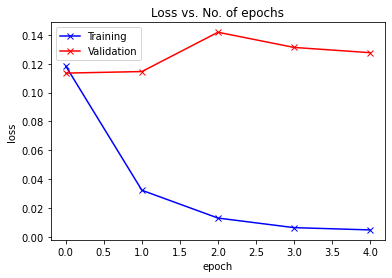

In [380]:
plot_losses(history_ft)

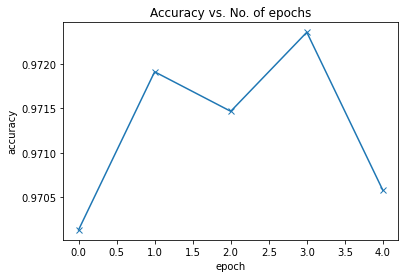

In [381]:
plot_accuracies(history_ft)

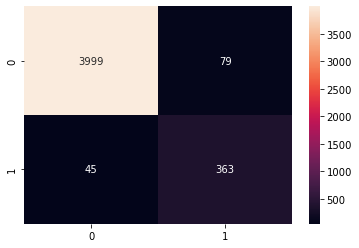

<AxesSubplot:>

In [382]:
show_confusion_matrix(model_ft, dls.valid)